# 0. Install Dependencies and Bring in Data

In [ ]:
!pip install tensorflow pandas matplotlib scikit-learn

In [ ]:
import os 
import pandas as pd
import tensorflow as tf
import numpy as np

In [ ]:
os.path.join("train.csv")

In [ ]:
df = pd.read_csv("train.csv")
df.head()

In [ ]:
df.tail()

In [ ]:
df.iloc[0]

In [ ]:
df.iloc[0]["comment_text"]

In [ ]:
df[df.columns[2:]]

In [ ]:
df[df.columns[2:]].iloc[3]

In [ ]:
df[df['toxic']==1].head()

# 1. Preprocess

In [ ]:
from tensorflow.keras.layers import TextVectorization # Used for tokenization

In [ ]:
#TextVectorization??

In [ ]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [ ]:
df.columns

In [ ]:
df[df.columns[2:]].values  # .values converts into the array

In [ ]:
MAX_FEATURES = 200000  # AMount of word textvectorization stores( vocabulary)

In [ ]:
vectorizer = TextVectorization(max_tokens = MAX_FEATURES,
                               output_sequence_length = 1800,  #Output sequence length means maximum no of words a sentence has
                               output_mode = "int")

In [ ]:
type(X)

In [ ]:
vectorizer.adapt(X.values)  # learning the vocabulary

In [ ]:
vectorizer('Hello world, life is great')[:5]

In [ ]:
#vectorizer.get_vocabulary()

In [ ]:
vectorized_text = vectorizer(X.values)

In [ ]:
vectorized_text

In [ ]:
# Creating a tensorflow data pipeline
#MCSHBAP pneumonic for data pipeline generation - map, cache, shuffle, batch, prefetch
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)  # helps prevents bottlenecks

In [ ]:
batch_X, batch_y = dataset.as_numpy_iterator().next()

In [ ]:
batch_y.shape

In [ ]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))


In [ ]:
len(train)
len(val)
len(test)

In [ ]:
train_generator = train.as_numpy_iterator()

In [ ]:
train_generator.next()

# 2. Create sequential model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [ ]:
#Bidirectional??

In [ ]:
model = Sequential()
model.add(Embedding(MAX_FEATURES+1,32))  # Create the embedding layer(+1 for if there are unknown words)
# Creating LSTM layer (LSTM requires tanh in tensorflow)
model.add(Bidirectional(LSTM(32, activation='tanh')))   # passes information to and fro from both sides, in NLP, this layer helps a lot
model.add(Dense(128, activation = 'relu'))  
model.add(Dense(256, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(6, activation = 'sigmoid'))  # Final layer 6 final outputs as array size (15971,6)

In [137]:
model.compile(loss = 'BinaryCrossentropy', optimizer = 'Adam')

In [138]:
history = model.fit(train, epochs = 1, validation_data =val)

6981/6981 ━━━━━━━━━━━━━━━━━━━━ 3533s 505ms/step - loss: 0.0850 - val_loss: 0.0451


In [139]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ (None, 1800, 32)            │       6,400,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 64)                  │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,475,060 (74.29 MB)

 Trainable params: 6,491,686 (24.76 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,983,374 (49.53 MB)

In [141]:
history.history

{'loss': [0.06246260926127434], 'val_loss': [0.04508434608578682]}

In [142]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

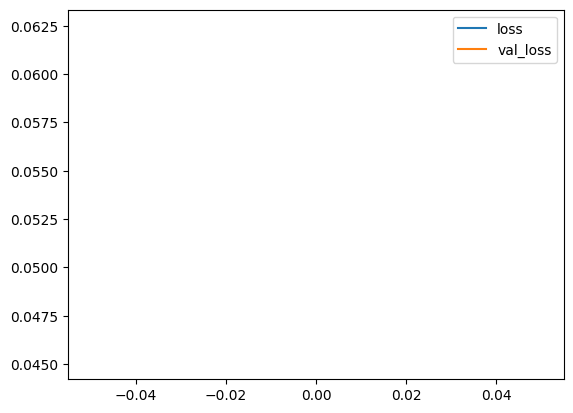

In [143]:
plt.figure(figsize = (8,5))
pd.DataFrame(history.history).plot()
plt.show()

# 3. Make Predictions

In [145]:
batch = test.as_numpy_iterator.next()

AttributeError: 'function' object has no attribute 'next'

In [144]:
input_text = vectorizer("You freaking suck!")

In [146]:
input_text

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([   7, 7158,  397, ...,    0,    0,    0])>

In [149]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [147]:
res = model.predict(np.expand_dims(input_text, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step


In [148]:
res

array([[0.98861563, 0.16188328, 0.9149855 , 0.03783515, 0.7966764 ,
        0.10579355]], dtype=float32)

# 4.Evaluate model

In [150]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [153]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [154]:
for batch in test.as_numpy_iterator():
    # Unpacking the batch
    X_true, y_true = batch
    # Making prediction
    yhat = model.predict(X_true)
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()

    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [155]:
print(f"Precision:{pre.result().numpy()}, Recall:{re.result().numpy()},Accuracy:{acc.result().numpy()}")

Precision:0.8455193042755127, Recall:0.6517341136932373,Accuracy:0.4854563772678375


# 5. Test and Gradio

In [156]:
!pip install gradio jinja2

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/59.6 MB ? eta -:--:--
   - -------------------------------------- 2.1/59.6 MB 11.7 MB/s eta 0:00:05
   -- ------------------------------------- 4.5/59.6 MB 11.7 MB/s eta 0:00:05
   ---- ----------------------------------- 6.6/59.6 MB 10.9 MB/s eta 0:00:05
   ----- ---------------------------------- 8.4/59.6 MB 10.4 MB/s eta 0:00:05
   ------- -------------------------------- 10.7/59.6 MB 10.6 MB/s eta 0:00:05
   -------- ------------------------------- 13.1/59.6 MB 10.7 MB/s eta 0:00:05
   ---------- ----------------------------- 15.5/59.6 MB 10.8 MB/s eta 0:00:05
   ----------- ---------------------------- 17.8/59.6 MB 10.9 MB/s eta 0:00:04
   ------------- -------------------------- 20.4/59.6 MB 11.0 MB/s eta 0:00:04
   --------------- ------------------------ 22.8/59.6 MB 11.1 MB/s eta 0:00:04
   ---------------- ----------------------- 25.2/59.6 MB 11.1 MB/s


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: C:\Users\satmv\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [160]:
import gradio as gr

In [163]:
model.save("Toxicity.h5")

In [164]:
model = tf.keras.models.load_model("Toxicity.h5")

In [165]:
input_str = vectorizer("hey i freakin hate you")

In [166]:
res = model.predict(np.expand_dims(input_str,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


In [167]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [168]:
res

array([[0.91340977, 0.02470807, 0.5899798 , 0.02032214, 0.4866026 ,
        0.06059546]], dtype=float32)

In [170]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)

    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)

    return text
        

In [174]:
# gradio interface
interface = gr.Interface(fn = score_comment,
                        inputs=gr.Textbox(lines=2, placeholder = 'Comment to score'),
                        outputs = 'text')

In [176]:
interface.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://c524e2a49c0ad99c05.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
